# 推荐系统

首先对音乐数据集进行数据清洗和特征提取，基于矩阵分解方式来进行音乐推荐。

- 音乐数据处理

读取音乐数据集，并统计其各项指标，选择有价值的信息当做我们的特征

- 基于商品相似性的推荐 

选择相似度计算方法，通过相似度来计算推荐结果

- 基于SVD矩阵分解的推荐

使用矩阵分解方法，快速高效得到推荐结果

In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3

data_home = './'

我们的数据中有一部分是数据库文件，使用sqlite3工具包来帮助我们进行数据的读取，关于数据的路径这个大家可以根据自己情况来设置。
先来看一下我们的数据长什么样子吧，对于不同格式的数据read_csv有很多参数可以来选择，例如分隔符与列名：

## 数据读取

在数据中只需要用户，歌曲，播放量

In [2]:
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt', 
                              sep='\t', header=None, 
                              names=['user','song','play_count'])

数据规模还是蛮大的

In [3]:
triplet_dataset.shape

(48373586, 3)

数据占用内存与各指标格式

In [4]:
triplet_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


如果想更详细的了解数据的情况，可以打印其info信息，来观察不同列的类型以及整体占用内存，这里教大家一个比较实用的技巧，如果拿到的数据非常大，对数据进行处理的时候可能会出现内存溢出的错误，这里最简单的方法就是设置下数据个格式，比如将float64用float32来替代，这样可以大大节省内存开销。

原始数据

In [5]:
triplet_dataset.head(n=10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


## 对每一个用户，分别统计他的播放总量

数据中有用户的编号，歌曲编号，已经用户对该歌曲播放的次数。
有了基础数据之后，我们还可以统计出关于用户与歌曲的各项指标，例如对每一个用户，分别统计他的播放总量，代码如下：

In [6]:
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前的用户
        user = line.split('\t')[0]
        #得到其播放量数据
        play_count = int(line.split('\t')[2])
        #如果字典中已经有该用户信息，在其基础上增加当前的播放量
        if user in output_dict:
            play_count +=output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
# 统计 用户-总播放量
output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
#转换成DF格式
play_count_df = pd.DataFrame(output_list)
#排序
play_count_df = play_count_df.sort_values(by = 'play_count', ascending = False)

构建一个字典结构来统计不同用户分别播放的总数，这需要我们把数据集遍历一遍。当我们的数据集比较庞大的时候，每一步操作都可能花费较长时间，后续操作中如果稍有不慎可能还得重头再来一遍，这就得不偿失了，最好还是把中间结果保存下来，既然我们已经把结果转换成df格式，直接使用to_csv()函数就可以完成保存的操作。

In [7]:
play_count_df.to_csv(path_or_buf='user_playcount_df.csv', index = False)

## 对于每一首歌，分别统计它的播放总量

In [8]:
#统计方法跟上述类似
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前歌曲
        song = line.split('\t')[1]
        #找到当前播放次数
        play_count = int(line.split('\t')[2])
        #统计每首歌曲被播放的总次数
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
#转换成df格式
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count', ascending = False)

In [9]:
song_count_df.to_csv(path_or_buf='song_playcount_df.csv', index = False)

## 看看目前的排行情况

In [10]:
play_count_df = pd.read_csv(filepath_or_buffer='user_playcount_df.csv')
play_count_df.head(n =10)

,user,play_count
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
2,3fa44653315697f42410a30cb766a4eb102080bb,8210
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6494
5,4ae01afa8f2430ea0704d502bc7b57fb52164882,6472
6,b7c24f770be6b802805ac0e2106624a517643c17,6150
7,113255a012b2affeab62607563d03fbdf31b08e7,5656
8,6d625c6557df84b60d90426c0116138b617b9449,5620
9,99ac3d883681e21ea68071019dba828ce76fe94d,5602


In [15]:
song_count_df = pd.read_csv(filepath_or_buffer='song_playcount_df.csv')
song_count_df.head(10)

,song,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880
5,SOAXGDH12A8C13F8A1,356533
6,SONYKOW12AB01849C9,292642
7,SOPUCYA12A8C13A694,274627
8,SOUFTBI12AB0183F65,268353
9,SOVDSJC12A58A7A271,244730


最受欢迎的一首歌曲有726885次播放。
刚才大家也看到了，这个音乐数据量集十分庞大，考虑到执行过程的时间消耗以及矩阵稀疏性问题，我们依据播放量指标对数据集进行了截取。因为有些注册用户可能只是关注了一下之后就不再登录平台，这些用户对我们建模不会起促进作用，反而增大了矩阵的稀疏性。对于歌曲也是同理，可能有些歌曲根本无人问津。由于之前已经对用户与歌曲播放情况进行了排序，所以我们分别选择了其中的10W名用户和3W首歌曲，关于截取的合适比例大家也可以通过观察选择数据的播放量占总体的比例来设置。

## 取其中一部分数（按大小排好序的了，这些应该是比较重要的数据），作为我们的实验数据

In [16]:
#10W名用户的播放量占总体的比例
total_play_count = sum(song_count_df.play_count)
print ((float(play_count_df.head(n=100000).play_count.sum())/total_play_count)*100)
play_count_subset = play_count_df.head(n=100000)

40.8807280500655


In [17]:
(float(song_count_df.head(n=30000).play_count.sum())/total_play_count)*100

78.39315366645269

In [18]:
song_count_subset = song_count_df.head(n=30000)

前3W首歌的播放量占到了总体的78.39%
现在已经有了这10W名忠实用户和3W首经典歌曲，接下来我们就要对原始数据集进行过滤清洗，说白了就是在原始数据集中剔除掉不包含这些用户以及歌曲的数据。

取10W个用户，3W首歌

In [19]:
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)

过滤掉其他用户数据

In [20]:
#读取原始数据集
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt',sep='\t', 
                              header=None, names=['user','song','play_count'])
#只保留有这10W名用户的数据，其余过滤掉
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset) ]
del(triplet_dataset)
#只保留有这3W首歌曲的数据，其余也过滤掉
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)

In [21]:
triplet_dataset_sub_song.to_csv(path_or_buf=data_home+'triplet_dataset_sub_song.csv', index=False)

当前我们的数据量

In [22]:
triplet_dataset_sub_song.shape

(10774558, 3)

数据样本个数此时只有原来的1/4不到，但是我们过滤掉的样本都是稀疏数据不利于建模，所以当拿到了数据之后对数据进行清洗和预处理工作还是非常有必要的，不单单提升计算的速度，还会影响最终的结果。

In [23]:
triplet_dataset_sub_song.head(n=10)

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7
503,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26
504,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7
505,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5
506,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1
507,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8


## 加入音乐详细信息

我们目前拿到的数据只有播放次数，可利用的信息实在太少了，对每首歌来说正常情况都应该有一份详细信息，例如歌手，发布时间，主题等，这些信息都存在一份数据库格式文件中，接下来我们就通过sqlite工具包来读取这些数据：

In [24]:
conn = sqlite3.connect(data_home+'track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [25]:
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]

In [26]:
track_metadata_df_sub.to_csv(path_or_buf=data_home+'track_metadata_df_sub.csv', index=False)

In [27]:
track_metadata_df_sub.shape

(30447, 14)

## 我们现有的数据

In [28]:
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer=data_home+'triplet_dataset_sub_song.csv',encoding = "ISO-8859-1")
track_metadata_df_sub = pd.read_csv(filepath_or_buffer=data_home+'track_metadata_df_sub.csv',encoding = "ISO-8859-1")

In [29]:
triplet_dataset_sub_song.head()

,user,song,play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


In [30]:
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
1,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
2,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
3,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
4,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


## 清洗数据集

去除掉无用的和重复的，数据清洗是很重要的一步

In [31]:
# 去掉无用的信息
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
# 去掉重复的
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
# 将这份音乐信息数据和我们之前的播放数据整合到一起
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, how='left', left_on='song', right_on='song_id')
# 可以自己改变列名
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

In [32]:
# 去掉不需要的指标
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

搞定数据，来看看它长什么样子吧

In [33]:
triplet_dataset_sub_song_merged.head(n=10)

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0
5,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26,You're The One,If There Was A Way,Dwight Yoakam,1990
6,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986
7,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5,S.O.S.,SOS,Jonas Brothers,2007
8,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1,The Invisible Man,The Invisible Man,Michael Cretu,1985
9,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8,American Idiot [feat. Green Day & The Cast Of ...,The Original Broadway Cast Recording 'American...,Green Day,0


现在的数据看起来工整多了，不光有用户对某个音乐作品的播放量，还有该音乐作品的名字和发布专辑，以及作者名字和发布时间。
现在我们只是大体了解了数据中各个指标的含义，对其具体内容还没有加以分析，我们在之前介绍推荐系统的时候提到过冷启动问题，就是一个新用户来了不知道给他推荐什么好，这时候就可以利用排行榜单了。可以统计最受欢迎的歌曲和歌手是哪些：

### 展示最流行的歌曲

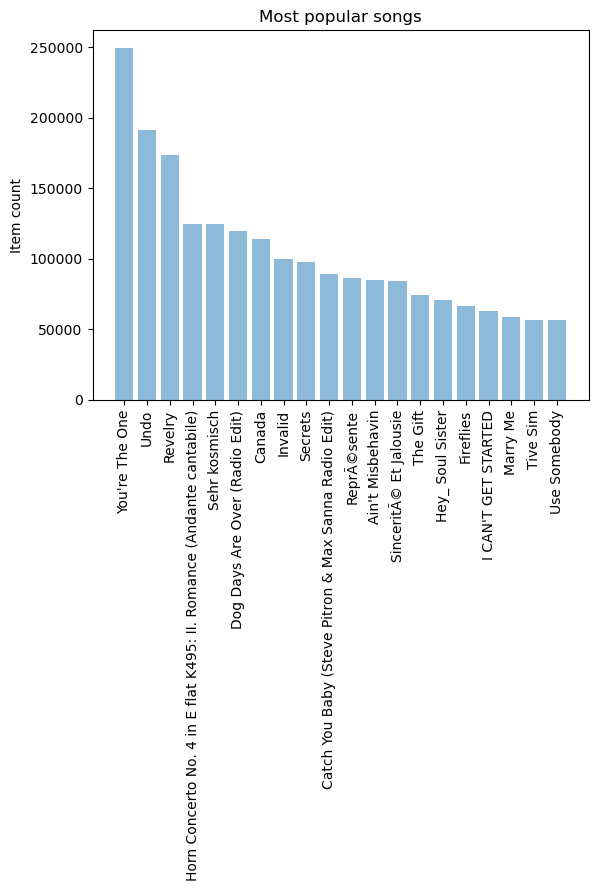

In [34]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#按歌曲名字来统计其播放量的总数
popular_songs = triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()
#对结果进行排序
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending=False).head(n=20)

#转换成list格式方便画图
objects = (list(popular_songs_top_20['title']))
#设置位置
y_pos = np.arange(len(objects))
#对应结果值
performance = list(popular_songs_top_20['listen_count'])
#绘图
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
 
plt.show()

这里展示了最受欢迎的歌曲，使用groupby函数可以很方便的对每首歌曲统计其播放情况，我们求的是总和也就是总播放量。这份排行数据就可以当做最受欢迎歌曲来推荐给用户了。
同样的方法我们还可以对专辑和歌手的播放情况分别进行统计：

### 最受欢迎的releases

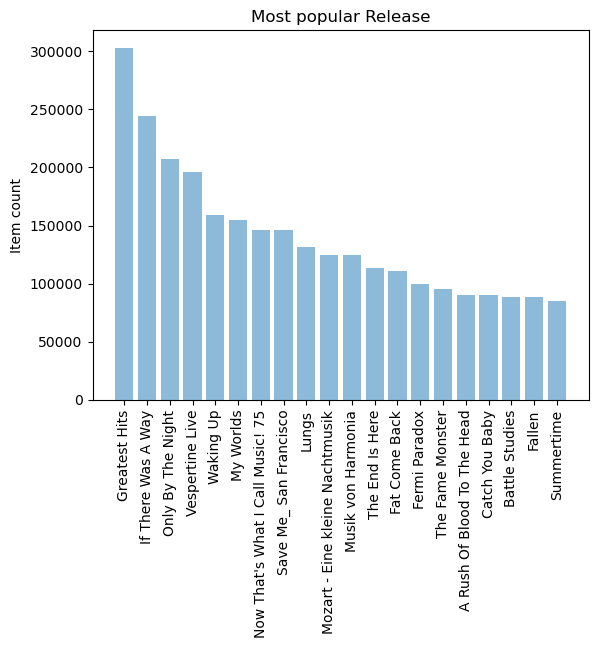

In [35]:
#按专辑名字来统计播放总量
popular_release = triplet_dataset_sub_song_merged[['release','listen_count']].groupby('release').sum().reset_index()
#排序
popular_release_top_20 = popular_release.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_release_top_20['release']))
y_pos = np.arange(len(objects))
performance = list(popular_release_top_20['listen_count'])
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Release')
 
plt.show()

## 最受欢迎的歌手

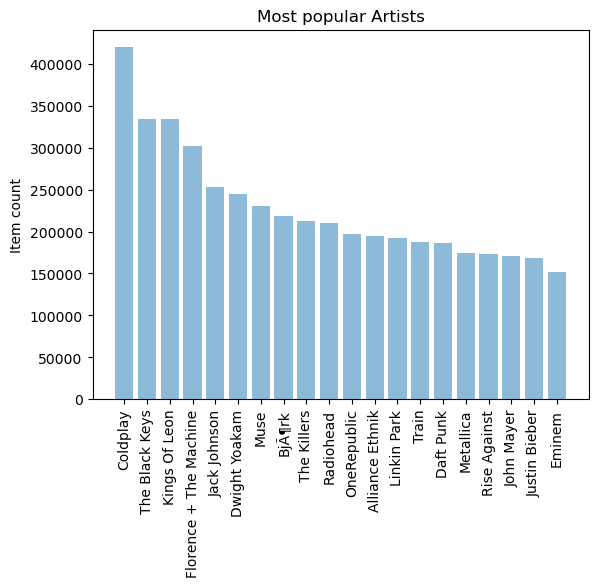

In [36]:
#按歌手来统计其播放总量
popular_artist = triplet_dataset_sub_song_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
#排序
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_artist_top_20['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artist_top_20['listen_count'])
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artists')
 
plt.show()

## 用户播放过歌曲量的分布

In [37]:
user_song_count_distribution = triplet_dataset_sub_song_merged[['user','title']].groupby('user').count().reset_index().sort_values(
by='title',ascending = False)
user_song_count_distribution.title.describe()

count    99996.000000
mean       107.749890
std         79.742561
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

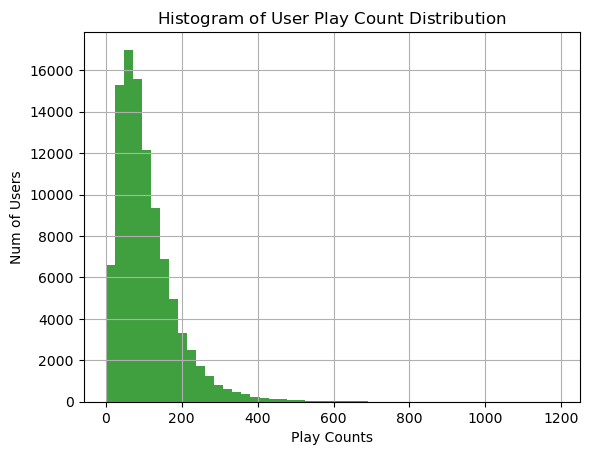

In [38]:
x = user_song_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)
plt.show()

绝大多数用户播放歌曲的数量在100左右，关于数据的处理和介绍已经给大家都分析过了，接下来我们要做的就是构建一个能实际进行推荐的程序了。

## 开始构建推荐系统

In [39]:
import Recommenders as Recommenders
from sklearn.model_selection import train_test_split

## 简单暴力，排行榜单推荐，对新用户来说解决冷启动问题

最简单的推荐方式就是排行榜单了，这里我们创建了一个函数，需要我们传入的是原始数据，用户列名，待统计的指标（例如按歌曲名字，歌手名字，专辑名字。选择统计哪项指标得到的排行榜单）：

In [40]:
triplet_dataset_sub_song_merged_set = triplet_dataset_sub_song_merged
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_set, test_size = 0.40, random_state=0)

In [41]:
train_data.head()

,user,song,listen_count,title,release,artist_name,year
1901799,28866ea8a809d5d46273cd0989c5515c660ef8c7,SOEYVHS12AB0181D31,1,Monster,The Fame Monster,Lady GaGa,2009
4815185,c9608a24a2a40e0ec38993a70532e7bb56eff22b,SOKIYKQ12A8AE464FC,2,Fight For Your Life,Made In NYC,The Casualties,2000
10513026,24f0b09c133a6a0fe42f097734215dceb468d449,SOETFVO12AB018DFF3,1,Free Style (feat. Kevo_ Mussilini & Lyrical 187),A Bad Azz Mix Tape,Z-RO,0
2659073,4da3c59a0af73245cea000fd5efa30384182bfcb,SOAXJOU12A6D4F6685,1,Littlest Things,Alright_ Still,Lily Allen,2006
5506263,b46c5ed385cad7ecea8af6214f440d19de6eb6c2,SOXBCAY12AB0189EE0,1,La trama y el desenlace,Amar la trama,Jorge Drexler,2010


In [42]:
def create_popularity_recommendation(train_data, user_id, item_id):
    #根据指定的特征来统计其播放情况，可以选择歌曲名，专辑名，歌手名
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    #为了直观展示，我们用得分来表示其结果
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #排行榜单需要排序
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #加入一项排行等级，表示其推荐的优先级
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    #返回指定个数的推荐结果
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [43]:
recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')

得到推荐结果

In [44]:
recommendations

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


返回了一份前20的歌曲排行榜单，其中的得分这里只是进行了简单的播放计算，在设计的时候也可以综合考虑更多的指标，比如综合计算歌曲发布年份，歌手的流行程度等。

## 基于歌曲相似度的推荐

接下来就要进行相似度的计算来推荐歌曲了，为了加快代码的运行速度，选择了其中一部分数据来进行实验。

In [45]:
song_count_subset = song_count_df.head(n=5000)
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [46]:
triplet_dataset_sub_song_merged_sub.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


### 计算相似度得到推荐结果

In [47]:
import Recommenders as Recommenders
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.30, random_state=0)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user', 'title')
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)

心的同学应该观察到了，我们首先导入了Recommenders，像是一个自定义的工具包，这里就包括了我们接下来要使用的所有函数，由于接下来进行计算的代码量较大，直接在notebook中进行展示比较麻烦，所有我们自己写了一个.py文件，所有的实际计算操作都在这里完成了。
大家在实践这份代码的时候，可以选择一个合适的IDE，因为notebook并不支持debug操作。拿到了一份陌生的代码而且量又比较大的时候，最好先通过debug的方式一行代码一行代码来执行，这样可以更清晰的熟悉整个函数做了一件什么事，如果直接看整体对于初学的同学们来说可能会有点难度，建议大家选择一个趁手的IDE例如pycharm,eclipse等都是不错的。

整体的代码量还是比较多，我先从整体上介绍这段代码做了一件什么事，大家在自己玩的时候最好按照我之前说的还是debug一遍更舒服。首先我们要针对某一个用户进行推荐，那必然得先得到他都听过哪些歌曲，通过这些已被听过的歌曲跟整个数据集中的歌曲进行对比，看哪些歌曲跟用户已听过的比较类似，推荐的就是这些类似的。如何计算呢？例如当前用户听过了66首歌曲，整个数据集中有4879个歌曲，我们要做的就是构建一个[66,4879]的矩阵，其中每一个值表示用户听过的每一个歌曲和数据集中每一个歌曲的相似度。这里使用Jaccard相似系数，矩阵中[i,j]的含义就是用户听过的第i首歌曲这些歌曲被哪些人听过，比如有3000人听过，数据集中的j歌曲被哪些人听过，比如有5000人听过。Jaccard相似系数就要求：

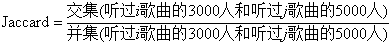

说白了就是如果两个歌曲很相似，那其受众应当是一致的，交集/并集的比例应该比较大，如果两个歌曲没啥相关性，其值应当就比较小了。
上述代码中计算了矩阵[66,4879]中每一个位置的值应当是多少，在最后推荐的时候我们还应当注意一件事对于数据集中每一个待推荐的歌曲都需要跟该用户所有听过的歌曲计算其Jaccard值，例如歌曲j需要跟用户听过的66个歌曲计算其值，最终是否推荐的得分值还得进行处理，即把这66个值加在一起，最终求一个平均值，来代表该歌曲的推荐得分。

In [48]:
#执行推荐
is_model.recommend(user_id)

No. of unique songs for the user: 66
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :290327


,user_id,song,score,rank
0,a974fc428825ed071281302d6976f59bfa95fe7e,Put Your Head On My Shoulder (Album Version),0.026334,1
1,a974fc428825ed071281302d6976f59bfa95fe7e,The Strength To Go On,0.025176,2
2,a974fc428825ed071281302d6976f59bfa95fe7e,Come Fly With Me (Album Version),0.024447,3
3,a974fc428825ed071281302d6976f59bfa95fe7e,Moondance (Album Version),0.024118,4
4,a974fc428825ed071281302d6976f59bfa95fe7e,Kotov Syndrome,0.023311,5
5,a974fc428825ed071281302d6976f59bfa95fe7e,Use Somebody,0.023104,6
6,a974fc428825ed071281302d6976f59bfa95fe7e,Lucky (Album Version),0.022930,7
7,a974fc428825ed071281302d6976f59bfa95fe7e,Secrets,0.022889,8
8,a974fc428825ed071281302d6976f59bfa95fe7e,Clocks,0.022562,9
9,a974fc428825ed071281302d6976f59bfa95fe7e,Sway (Album Version),0.022359,10


## 基于矩阵分解（SVD）的推荐

相似度计算的方法看起来比较简单就是实现出来，但是当数据较大的时候计算的时间消耗实在太大了，对每一个用户都需要多次遍历整个数据集来进行计算，矩阵分解的方法是当下更常使用的方法。

奇异值分解(Singular Value Decomposition，SVD)是矩阵分解中一个经典方法，接下来我们的推荐就可以SVD来进行计算，奇异值分解的基本出发点跟我们之前讲的隐语义模型有些类似都是将大矩阵转换成小矩阵的组合,基本形式如下图所示：

<img src="1.png" style="width:550px;height:280px;float:left">
<img src="5.png" style="width:350px;height:280px;float:left">

对矩阵进行SVD分解，将得到USV

<img src="2.png" style="width:500px;height:380px;float:left"><img src="3.png" style="width:400px;height:200px;float:left">

重新计算 U*S*V的结果得到A2 来比较下A2和A的差异，看起来差异是有的，但是并不大，所以我们可以近似来代替

<img src="4.png" style="width:330px;height:220px;float:left">
<img src="5.png" style="width:330px;height:220px;float:left">

<img src="6.png" style="width:650px;height:480px;float:left">

<img src="7.png" style="width:650px;height:480px;float:left">

在SVD中我们所需的数据是用户对商品的打分，但是我们现在的数据集中只有用户播放歌曲的情况并没有实际的打分值，所以我们还得自己来定义一下用户对每个歌曲的评分值。如果一个用户喜欢某个歌曲，那应该经常播放这个歌曲，相反如果不喜欢某个歌曲，那播放次数肯定就比较少了。
用户对歌曲的打分值，定义为：用户播放该歌曲数量/该用户播放总量。代码如下：

In [49]:
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004,329
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007,329
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0,329
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993,329
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329


In [50]:
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count']/triplet_dataset_sub_song_merged['total_listen_count']

大概是这样

In [51]:
triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea'][['user','song','listen_count','fractional_play_count']].head()

,user,song,listen_count,fractional_play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.036474
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003040
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003040
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003040
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.021277


In [52]:
from scipy.sparse import coo_matrix

small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [53]:
data_sparse

<99996x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 10774558 stored elements in COOrdinate format>

上面代码先根据用户进行分组，计算每个用户的总的播放总量，然后用每首歌的播放总量相处，得到每首歌的分值，最后一列特征fractional_play_count就是用户对每首歌曲的评分值。
有了评分值之后就可以来构建矩阵了，这里有一些小问题需要处理一下，原始数据中无论是用户ID还是歌曲ID都是很长一串，这表达起来不太方便，需要重新对其制作索引。

In [54]:
user_codes[user_codes.user =='2a2f776cbac6df64d6cb505e7e834e01684673b6']

,user_index,user,us_index_value
27516,2981434,2a2f776cbac6df64d6cb505e7e834e01684673b6,27516


### 使用SVD方法来进行矩阵分解

矩阵构造好了之后我们就要执行SVD矩阵分解了，这里还需要一些额外的工具包来帮助我们完成计算，scipy就是其中一个好帮手了，里面已经封装好了SVD计算方法。

In [55]:
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [56]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

在执行SVD的时候需要我们额外指定一个指标K值，其含义就是我们选择前多少个特征值来做近似代表，也就是S矩阵中的数量。如果K值较大整体的计算效率会慢一些但是会更接近真实结果，这个值还需要我们自己来衡量一下。

In [57]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)

这里我们选择K值等于50，其中PID表示我们最开始选择的部分歌曲，UID表示我们选择的部分用户。

执行过程中，可以打印出各个矩阵的大小，这里强烈建议大家将代码复制到IDE中，打上断点一行一行的走下面，观察其中每一个变量的值，这对理解整个流程是非常有帮助的。

接下来我们需要选择待测试用户了：

uTest = [4,5,6,7,8,873,23]

随便选择一些用户就好，这里表示用户的索引编号，接下来需要对每一个用户计算其对我们候选集中3W首歌曲的喜好程度，说白了就是估计他对这3W首歌的评分值应该等于多少，前面我们通过SVD矩阵分解已经计算所需各个小矩阵了，接下来把其还原回去就可以啦：

In [58]:
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

In [59]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

Recommendation for user with user id 4
The number 1 recommended song is Fireflies BY Charttraxx Karaoke
The number 2 recommended song is Hey_ Soul Sister BY Train
The number 3 recommended song is OMG BY Usher featuring will.i.am
The number 4 recommended song is Lucky (Album Version) BY Jason Mraz & Colbie Caillat
The number 5 recommended song is Vanilla Twilight BY Owl City
The number 6 recommended song is Crumpshit BY Philippe Rochard
The number 7 recommended song is Billionaire [feat. Bruno Mars]  (Explicit Album Version) BY Travie McCoy
The number 8 recommended song is Love Story BY Taylor Swift
The number 9 recommended song is TULENLIEKKI BY M.A. Numminen
The number 10 recommended song is Use Somebody BY Kings Of Leon
Recommendation for user with user id 5
The number 1 recommended song is Sehr kosmisch BY Harmonia
The number 2 recommended song is Ain't Misbehavin BY Sam Cooke
The number 3 recommended song is Dog Days Are Over (Radio Edit) BY Florence + The Machine
The number 4 reco

这里对每一个用户都得到了其对应的推荐结果，并且将结果按照得分值进行排序。


本章我们选择了音乐数据集来进行个性化推荐任务，首先对数据进行预处理和整合，选择两种方法分别完成推荐任务。在相似度计算中根据用户所听过的歌曲在候选集中选择与其最相似的歌曲，存在的问题就是计算时间消耗太多，每一个用户都需要重新计算一遍才能得出推荐结果。在SVD矩阵分解的方法中，我们首先构建评分矩阵，对其进行SVD分解，然后选择待推荐用户，还原得到其对所有歌曲的估测评分值，最后排序返回结果即可。

In [60]:
uTest = [27513]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

Predictied ratings:


In [61]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

Recommendation for user with user id 27513
The number 1 recommended song is Master Of Puppets BY Metallica
The number 2 recommended song is Garden Of Eden BY Guns N' Roses
The number 3 recommended song is Bring Me To Life BY Evanescence
The number 4 recommended song is Kryptonite BY 3 Doors Down
The number 5 recommended song is Make Her Say BY Kid Cudi / Kanye West / Common
The number 6 recommended song is Night Village BY Deep Forest
The number 7 recommended song is Savior BY Rise Against
The number 8 recommended song is Good Things BY Rich Boy / Polow Da Don / Keri Hilson
The number 9 recommended song is Bleed It Out [Live At Milton Keynes] BY Linkin Park
The number 10 recommended song is Uprising BY Muse
